In [28]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import scipy.stats as st
from tqdm import tqdm
from math import gamma
from numba import njit
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from random import choices
import detection as dtc
import fitting
import emission
from constants import *
import cross_sections as cs
from numba import njit
from joblib import Parallel, delayed
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy import units as u
import datetime
import scipy.linalg as la
from scipy.interpolate import griddata
from matplotlib import scale, ticker, cm
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter
from scipy.interpolate import interp1d
from decimal import Decimal
from scipy.signal import lfilter

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [12]:
# https://en.wikipedia.org/wiki/Neutrino_oscillation
theta_12 = 33.447*2*np.pi/360
theta_23 = 45*2*np.pi/360
theta_13 = 8.878*2*np.pi/360
delta_cp = 0#195*2*np.pi/360

c_12 = np.cos(theta_12)
c_13 = np.cos(theta_13)
c_23 = np.cos(theta_23)
s_12 = np.sin(theta_12)
s_13 = np.sin(theta_13)
s_23 = np.sin(theta_23)

U = np.array([[c_12*c_13, s_12*c_13, s_13*np.exp(-1j*delta_cp)],
             [-s_12*c_23-c_12*s_23*s_13*np.exp(1j*delta_cp), c_12*c_23-s_12*s_23*s_13*np.exp(1j*delta_cp), s_23*c_13],
             [s_12*s_23-c_12*c_23*s_13*np.exp(1j*delta_cp), -c_12*s_23-s_12*c_23*s_13*np.exp(1j*delta_cp), c_23*c_13]])

#delta_m = np.array([2.44e-3, 7.53e-5, 2.44e-3])
delta_m = {'m_10': 7.53e-2, 'm_20': 2.44, 'm_21': 2.44,
           'm_01': 7.53e-2, 'm_02': 2.44, 'm_12': 2.44} #eV²

In [13]:
R_earth = 6371 # Km
R_core = 3486 # Km
phi = np.linspace(0, np.pi/2, 2000)
E = np.linspace(0, 70, 2000) # MeV
delta_mbar = 7.54 # eV^2
theta_12 = 33.447*np.pi/180
Avog = 6.022e23
N_e_m = 2.2#*Avog # cm^-3
N_e_c = 5.2#*Avog # cm^-3

c = 2.99792458e8 #m/s
G_F = 1.16632e-23 #eV^-2
Na = 6.022e23
g_to_eV = c**2/1000 * 6.242e18
cm3_to_eV3 = (0.197e9*1e-15*100)**3

In [14]:
data_ea = np.loadtxt('Data/Earth_density_profile_kg_per_m3.txt', delimiter=';', skiprows=4)
data_ea_mol_e = np.loadtxt('Data/Earth_density_profile_mols_electron_per_cm3.txt', delimiter=';',
                           skiprows=4)
r_data_earth = data_ea[:,0] #km
rho_earth = data_ea[:,1]*1e3/1e6# * Na #cm^-3 #* cm3_to_eV3 #eV^3
r_data_earth_mols = data_ea_mol_e[:,0]
ne_earth = data_ea_mol_e[:,1]

In [15]:
# r_data_earth = np.concatenate(([0], r_data_earth))
# rho_earth = np.concatenate(([rho_earth[0]], rho_earth))

r_data_earth_two_sides = np.concatenate((-r_data_earth, r_data_earth))
r_data_earth_two_sides.sort()
rho_earth_two_sides = np.concatenate((rho_earth[::-1], rho_earth))

In [16]:
f_density = interp1d(r_data_earth, rho_earth, fill_value = 'extrapolate')

In [17]:
def nu_path(nadir):
    L = R_earth*np.sqrt(2*(1-np.cos(2*nadir)))
    path = np.linspace(0, L, 10000)
    rho_path = []
    for i in range(len(path)):
        r = np.sqrt(R_earth**2 + path[i]**2 - 2*R_earth*path[i]*np.cos(np.pi/2 - nadir))
        rho_path.append(f_density(r))
    rho_path = np.array(rho_path)
    return path, rho_path

In [18]:
super_k_lat = 36.42*np.pi/180
super_k_lon = 137.31*np.pi/180
z = R_earth*np.cos(np.pi/2 - super_k_lat)
x = R_earth*np.sin(np.pi/2 - super_k_lat)*np.cos(super_k_lon)
y = R_earth*np.sin(np.pi/2 - super_k_lat)*np.sin(super_k_lon)

In [19]:
RA = 80.745
Dec = -69.75
RA_sn1987 = 80.745
Dec_sn1987 = -69.75

In [20]:
detec_time = datetime.datetime.utcnow()
detec_sn1987 = datetime.datetime(1987,2,23,23,0,0)

In [21]:
observing_location = EarthLocation(lat=0*u.deg, lon=0*u.deg)
observing_time = Time(detec_time, scale='utc', location=observing_location)
observing_time_sn1987 = Time(detec_sn1987, scale='utc', location=observing_location)
GMST = observing_time.sidereal_time('mean')
GMST_sn1987 = observing_time_sn1987.sidereal_time('mean')
GMST_deg = GMST.hour*15
GMST_deg_sn1987 = GMST_sn1987.hour*15

In [22]:
# nu_lat = -36.42*np.pi/180
# nu_lon = 137.31*np.pi/180 - np.pi
nu_lat = Dec
nu_lon = (RA - GMST_deg)*np.pi/180

sn1987_lat = Dec_sn1987
sn1987_lon = (RA_sn1987 - GMST_deg_sn1987)*np.pi/180

z2 = R_earth*np.cos(np.pi/2 - nu_lat)
x2 = R_earth*np.sin(np.pi/2 - nu_lat)*np.cos(nu_lon)
y2 = R_earth*np.sin(np.pi/2 - nu_lat)*np.sin(nu_lon)

z3 = R_earth*np.cos(np.pi/2 - sn1987_lat)
x3 = R_earth*np.sin(np.pi/2 - sn1987_lat)*np.cos(sn1987_lon)
y3 = R_earth*np.sin(np.pi/2 - sn1987_lat)*np.sin(sn1987_lon)

In [23]:
A = [x, y, z]
B = [x2, y2, z2]
C = [x3, y3, z3]

In [24]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [25]:
alpha = angle_between(A, np.subtract(A, B))#*180/np.pi
alpha2 = angle_between(A, np.subtract(A, C))#*180/np.pi

In [26]:
nadir = np.pi/2 - alpha
nadir2 = np.pi/2 - alpha2

In [27]:
path_length, path_dens = nu_path(nadir)
path_length_sn1987, path_dens_sn1987 = nu_path(nadir2)

In [31]:
nadir*180/np.pi

75.93707742000181

Considering a incoming neutrino in a mass eigenstate $\nu_3$, we have $\Psi_0 = (0,0,1)$.

In [3]:
Psi_0 = [0, 0, 1]

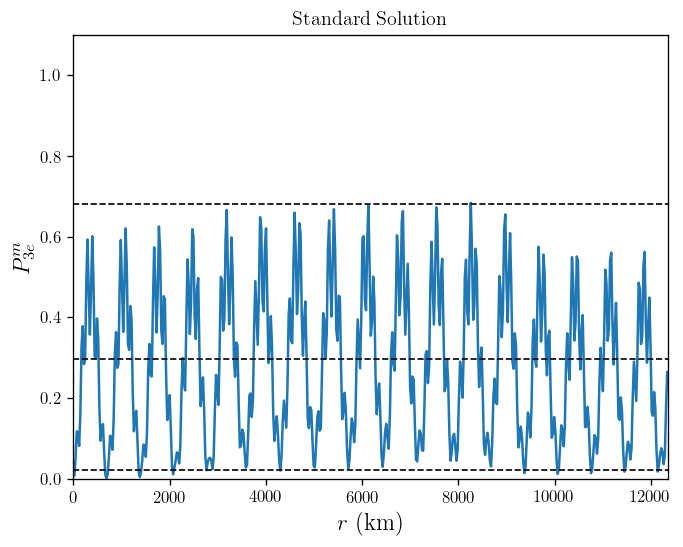

In [55]:
n = 501
E = 20 #MeV
Hier = 'NH'

Deltam21 = 7.42e-5 #eV² +0.21 -0.20
Deltam31 = 2.510e-3 #NH #eV² +-0.027
Deltam32 = Deltam31 - Deltam21

c12=np.cos(theta12)
s12=np.sin(theta12)
c13=np.cos(theta13)
s13=np.sin(theta13)
c23=np.cos(theta23)
s23=np.sin(theta23)

U23 = np.array([ [1,0,0],[0,c23,s23],[0,-s23,c23] ])
U13 = np.array([ [c13,0,s13],[0,1,0],[-s13,0,c13] ])
U12 = np.array([ [c12,s12,0],[-s12,c12,0],[0,0,1] ])
U3 = U23 @ U13 @ U12
U3_dag = np.transpose(U3)

c = 2.99792458e8 #m/s
Gf = 1.16632e-23 #eV^-2
Na = 6.022e23
g_to_eV = c**2/1000 * 6.242e18
cm3_to_eV3 = (0.197e9*1e-15*100)**3


#Energy in MeV and rho in g cm^-3
def diag(E, Vcc0):
	E = E*1e6
	Deltam21 = 7.42e-5 #eV² +0.21 -0.20
	Deltam31 = 2.510e-3 #NH #eV² +-0.027
	Deltam32 = Deltam31 - Deltam21
	if Hier == 'NH':
		Deltam31 = Deltam31
	elif Hier == 'IH':
		Deltam31 = -Deltam31
	M2 = np.array([[0,0,0],[0,Deltam21,0],[0,0,Deltam31]])

	#Hamiltonian in flavour basis
	M2f = U3 @ M2 @ U3_dag
	
	#Potential in matter
	Vcc = np.array([[Vcc0,0.,0.],[0.,0.,0.],[0.,0.,0.]])

	Hf = 1/(2*E) * M2f + Vcc

	#eigenvalues
	# eigvals, eigvecs = la.eig(U3_dag@Hmat@U3)
	eigvals, eigvecs = la.eig(Hf)
	eigvals = eigvals.real
	# print('Esse:')
	# print(eigvecs)

	#sorting eigenvalues list
	id_sor = np.argsort(abs(eigvals))

	#adding eigenvalues to a list
	eval1 = eigvals[id_sor[0]]
	eval2 = eigvals[id_sor[1]]
	eval3 = eigvals[id_sor[2]]

	#collecting eigenvectors from sorted eigenvalues
	eve1 = eigvecs[:,id_sor[0]]
	eve2 = eigvecs[:,id_sor[1]]
	eve3 = eigvecs[:,id_sor[2]]

	#Eigenvector for electron neutrino spectrum
	Ue1 = (eve1[0])
	Ue2 = (eve2[0])
	Ue3 = (eve3[0])
	#Eigenvector for muon neutrino spectrum
	Umu1 = (eve1[1])
	Umu2 = (eve2[1])
	Umu3 = (eve3[1])
	#Eigenvector for tau neutrino spectrum
	Utau1 = (eve1[2])
	Utau2 = (eve2[2])
	Utau3 = (eve3[2])

	Um3 = np.array([[Ue1,Ue2,Ue3],
				[Umu1,Umu2,Umu3],
				[Utau1,Utau2,Utau3]])
	Um3_dag = np.transpose(np.conjugate(Um3))

	return eval1, eval2, eval3, Um3, Um3_dag

#Earth profile already taken with respect to the nadir angle
r_data_earth = path_length #km
ne_earth = path_dens * cm3_to_eV3 * Na #eV^3

ne_f = interp1d(r_data_earth, ne_earth, kind='slinear', fill_value='extrapolate')

#r in km, ne in eV^3
def ne_func_earth(r):
    if type(r) == np.ndarray:
        ne_array = np.where(ne_f(r)<0, 0, ne_f(r))
    else:
        if ne_f(r) < 0:
            ne_array = 0
        else:
            ne_array = ne_f(r)
    return ne_array

#initial point of trajectory
r0 = r_data_earth[0] #km
#final point of trajectory
rf = r_data_earth[-1] #km
r_list = np.linspace(r0, rf, n) #km
Pee_list = []
k = 0

#loop over all points in the Earth potential
for r in r_list[1:]:
	vcc0 = np.sqrt(2) * Gf * ne_func_earth(r)
	idx = list(r_list).index(r)
	Delta_x_km = r - r_list[idx-1]
	Delta_x_eV = Delta_x_km/(0.197e9 * 1e-15 / 1000) #eV^-1
	eval1, eval2, eval3, Um, Um_dag = diag(E, vcc0)
	exp_Hm = np.array([[np.exp(-1j*eval1*Delta_x_eV), 0, 0],
					   [0, np.exp(-1j*eval2*Delta_x_eV), 0],
					   [0, 0, np.exp(-1j*eval3*Delta_x_eV)]])
	# print(k,r,'km')
	if k == 0:
		U = Um @ exp_Hm @ Um_dag
		# Psi_0 = np.transpose(array([1,0,0]))
		Psi = U @ Psi_0
		# print(Psi)
		# print(Um)
	else:
		U = Um @ exp_Hm @ Um_dag
		Psi = U @ Psi
	
	# print(Psi)
	Pee = np.abs(Psi[0])**2
	Pee_list.append(Pee)
	k = k+1

	# print(abs(Um[0,0])**2,abs(Um[0,1])**2,abs(Um[0,2])**2)

plt.figure(dpi=120)
# plt.plot(r_list[1:], np.array(Pee_list)+U3[0,1]**2, lw=1.5)
plt.plot(r_list[1:], np.array(Pee_list), lw=1.5)
plt.plot(r_list, np.ones(len(r_list))*U3[0,0]**2, 'k--', lw = 1)
plt.plot(r_list, np.ones(len(r_list))*U3[0,1]**2, 'k--', lw = 1)
plt.plot(r_list, np.ones(len(r_list))*U3[0,2]**2, 'k--', lw = 1)
plt.title(r'Standard Solution')
plt.xlim(r0, rf)
plt.ylim(0,1.1)
plt.xlabel(r'$r$ (km)', fontsize=14)
plt.ylabel(r'$P_{3e}^m$', fontsize=14)
plt.show()

In [53]:
np.abs(Psi)**2

array([0.15958108, 0.50241551, 0.33800341])

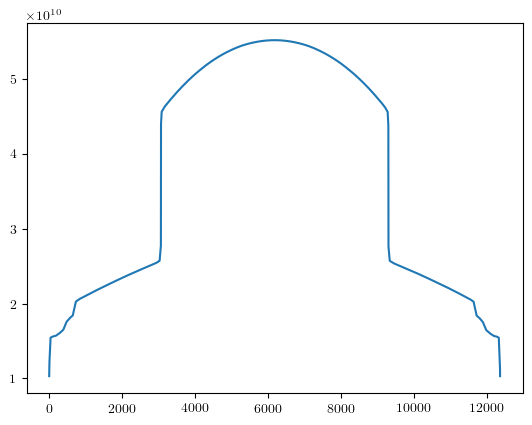

In [49]:
# plt.plot(path_length, path_dens)
plt.plot(r_data_earth, ne_earth)
plt.show()

In [90]:
Psi_0 = np.array([[0,0,1],
                 [0,1,0],
                 [1,0,0]])

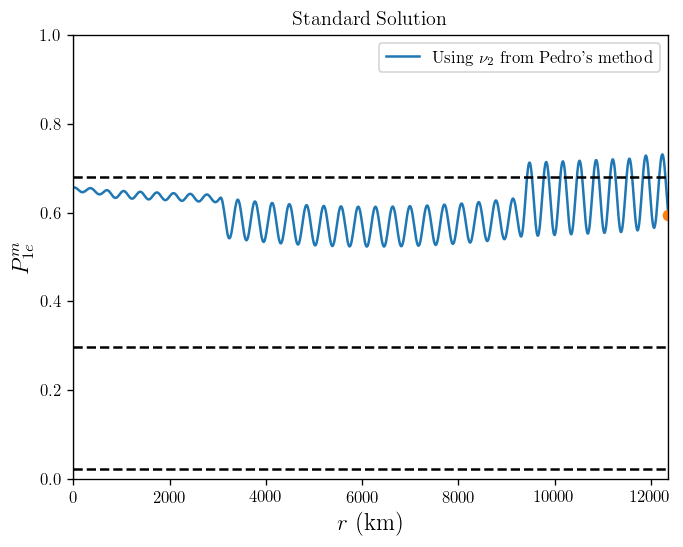

0.5937809225072427

In [118]:
n = 1001

Deltam21 = 7.42e-5 #eV² +0.21 -0.20
Deltam31 = 2.510e-3 #NH #eV² +-0.027
Deltam32 = Deltam31 - Deltam21

c12=np.cos(theta12)
s12=np.sin(theta12)
c13=np.cos(theta13)
s13=np.sin(theta13)
c23=np.cos(theta23)
s23=np.sin(theta23)

U23 = np.array([ [1,0,0],[0,c23,s23],[0,-s23,c23] ])
U13 = np.array([ [c13,0,s13],[0,1,0],[-s13,0,c13] ])
U12 = np.array([ [c12,s12,0],[-s12,c12,0],[0,0,1] ])
U3 = U23 @ U13 @ U12
U3_dag = np.transpose(U3)

c = 2.99792458e8 #m/s
Gf = 1.16632e-23 #eV^-2
Na = 6.022e23
g_to_eV = c**2/1000 * 6.242e18
cm3_to_eV3 = (0.197e9*1e-15*100)**3

#Earth profile----------
r_data_earth = path_length #km
ne_earth = path_dens * cm3_to_eV3 * Na #eV^3

#r in km, ne in eV^3
def ne_func_earth(r, ne_f):
    if type(r) == np.ndarray:
        ne_array = np.where(ne_f(r)<0, 0, ne_f(r))
    else:
        if ne_f(r) < 0:
            ne_array = 0
        else:
            ne_array = ne_f(r)
    return ne_array

#Energy in MeV, Gamma in eV
def Pje_Earth(E, nu_path, path_dens, mix, j, nu_nubar, Deltam21, Deltam31, U3, show_plot = True):
    E = E*1e6 #eV
    nearth = 1001
    Pee_list = []
    #imaginary number
    i = 1j
    k = 0
    ne_f = interp1d(nu_path, path_dens, kind='slinear', fill_value='extrapolate')

    #Energy in MeV and rho in g cm^-3
    def diag(E, Vcc0):
        #Re-evaluating the M2 with the E parameter for the function
        if mix == 'NH':
            M2 = np.array([[0,0,0],[0,Deltam21,0],[0,0,Deltam31]])
        elif mix == 'IH':
            M2 = np.array([[0,0,0],[0,Deltam21,0],[0,0,-Deltam31]])
        if nu_nubar == 'nuebar':
            Vcc0 = -Vcc0

        #Hamiltonian in flavour basis
        M2f = U3 @ M2 @ U3_dag
        
        #Potential in matter
        Vcc = np.array([[Vcc0,0.,0.],[0.,0.,0.],[0.,0.,0.]])

        Hf = 1/(2*E) * M2f + Vcc

        #eigenvalues
        eigvals, eigvecs = la.eig(Hf)
        eigvals = eigvals.real

        #sorting eigenvalues list
        id_sor = np.argsort(abs(eigvals))

        #adding eigenvalues to a list
        eval1 = eigvals[id_sor[0]]
        eval2 = eigvals[id_sor[1]]
        eval3 = eigvals[id_sor[2]]

        #collecting eigenvectors from sorted eigenvalues
        eve1 = eigvecs[:,id_sor[0]]
        eve2 = eigvecs[:,id_sor[1]]
        eve3 = eigvecs[:,id_sor[2]]

        #Eigenvector for electron neutrino spectrum
        Ue1 = (eve1[0])
        Ue2 = (eve2[0])
        Ue3 = (eve3[0])
        #Eigenvector for muon neutrino spectrum
        Umu1 = (eve1[1])
        Umu2 = (eve2[1])
        Umu3 = (eve3[1])
        #Eigenvector for tau neutrino spectrum
        Utau1 = (eve1[2])
        Utau2 = (eve2[2])
        Utau3 = (eve3[2])

        Um3 = np.array([[Ue1,Ue2,Ue3],
                     [Umu1,Umu2,Umu3],
                     [Utau1,Utau2,Utau3]])
        Um3_dag = np.transpose(np.conjugate(Um3))

        return eval1, eval2, eval3, Um3, Um3_dag

    #initial radius of the Earth
    r0 = min(nu_path) #km
    #final radius to calculate Pee
    rf = max(nu_path) #km
    r_list = np.linspace(r0, rf, n) #km
    Pee_list = []
    k = 0

    #loop over all points in the SN potential
    for r in r_list[1:]:
        vcc0 = np.sqrt(2) * Gf * ne_func_earth(r, ne_f)
        id = list(r_list).index(r)
        Delta_x_km = r - r_list[id-1]
        Delta_x_eV = Delta_x_km/(0.197e9 * 1e-15 / 1000) #eV^-1

        eval1, eval2, eval3, Um, Um_dag = diag(E, vcc0)
        exp_Hm = np.array([[np.exp(-i*eval1*Delta_x_eV), 0, 0],
                        [0, np.exp(-i*eval2*Delta_x_eV), 0],
                        [0, 0, np.exp(-i*eval3*Delta_x_eV)]])
        if k == 0:
            U = Um @ exp_Hm @ Um_dag
            nue_0 = np.array([1,0,0])
            numu_0 = np.array([0,1,0])
            nutau_0 = np.array([0,0,1])
            if j == '1':
                nu1_0 = Um_dag[0,0] * nue_0 + Um_dag[0,1] * numu_0 + Um_dag[0,2] * nutau_0
                nui = U @ nu1_0
            elif j == '2':
                nu2_0 = Um_dag[1,0] * nue_0 + Um_dag[1,1] * numu_0 + Um_dag[1,2] * nutau_0
                nui = U @ nu2_0
            elif j == '3':
                nu3_0 = Um_dag[2,0] * nue_0 + Um_dag[2,1] * numu_0 + Um_dag[2,2] * nutau_0
                nui = U @ nu3_0
            
        else:
            U = Um @ exp_Hm @ Um_dag
            nui = U @ nui

        nue_0 = np.array([1,0,0])
        Pee = abs(nui @ nue_0)**2
        Pee_list.append(Pee)
        k = k+1

    if show_plot:
        plt.figure(dpi=120)
        # plt.plot(r_list[1:], Pee_list_old, lw=1.5, label=r'Using SN $\nu_2$ state')
        plt.plot(r_list[1:], Pee_list, '-', lw=1.5, label=r"Using $\nu_2$ from Pedro's method")
        plt.legend()
        plt.plot(r_list, np.ones(len(r_list))*U3[0,0]**2, 'k--')
        plt.plot(r_list, np.ones(len(r_list))*U3[0,1]**2, 'k--')
        plt.plot(r_list, np.ones(len(r_list))*U3[0,2]**2, 'k--')
        plt.plot(r_data_earth[0]*np.ones(len(r_list)), np.linspace(0,1.1,len(r_list)), 'k-',alpha=0.1)
        plt.plot(r_data_earth[-1]*np.ones(len(r_list)), np.linspace(0,1.1,len(r_list)), 'k-',alpha=0.1)
        plt.title(r'Standard Solution')
        plt.xlim(r0, rf)
        plt.ylim(0,1.)
        plt.xlabel(r'$r$ (km)', fontsize=14)
        if j == '3':
            plt.ylabel(r'$P_{3e}^m$', fontsize=14)
        elif j == '2':
            plt.ylabel(r'$P_{2e}^m$', fontsize=14)
        elif j == '1':
            plt.ylabel(r'$P_{1e}^m$', fontsize=14)
        plt.plot(max(r_data_earth),Pee,'o')
        plt.show()

    return Pee

Pje_Earth(E=10, nu_path = r_data_earth, path_dens = ne_earth, mix='NH', j='1', nu_nubar='nue', Deltam21=Deltam21, Deltam31=Deltam31, U3=U3)

In [319]:
P_1e = np.zeros((100,200))
P_2e = np.zeros((100,200))
P_3e = np.zeros((100,200))

for i in tqdm(range(100)):
    nadir = 0.9*(i+1)*np.pi/180
    path_length, path_dens = nu_path(nadir)
    ne_earth = path_dens * cm3_to_eV3 * Na #eV^3
    for j in range(200):
        E = 0.5*(j+1)
        P_1e[i,j] = Pje_Earth(E=E, nu_path = path_length, path_dens = ne_earth, mix='IH', j='1', nu_nubar='nuebar', Deltam21=Deltam21, Deltam31=Deltam31, U3=U3, show_plot = False)
        P_2e[i,j] = Pje_Earth(E=E, nu_path = path_length, path_dens = ne_earth, mix='IH', j='2', nu_nubar='nuebar', Deltam21=Deltam21, Deltam31=Deltam31, U3=U3, show_plot = False)
        P_3e[i,j] = Pje_Earth(E=E, nu_path = path_length, path_dens = ne_earth, mix='IH', j='3', nu_nubar='nuebar', Deltam21=Deltam21, Deltam31=Deltam31, U3=U3, show_plot = False)

100%|██████████| 100/100 [3:43:03<00:00, 133.84s/it] 


In [320]:
nadir = np.array([0.9*(i+1) for i in range(100)])
E = np.array([0.5*(j+1) for j in range(200)])

In [321]:
X, Y = np.meshgrid(E, nadir)

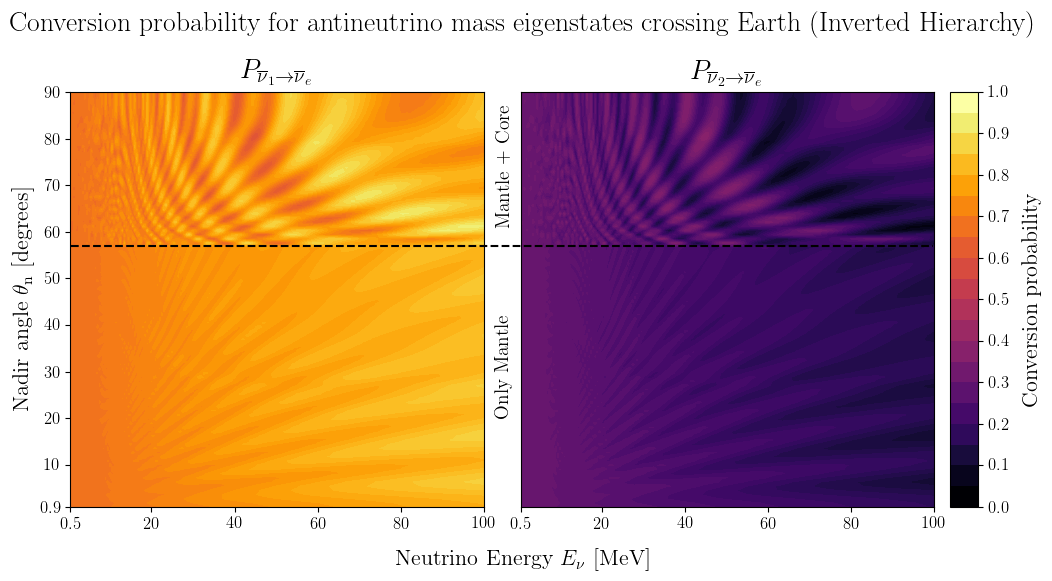

In [325]:
cmap = 'inferno'
fig, ax = plt.subplots(1, 3, figsize=(14,5))
im1 = ax[0].contourf(X, Y, P_1e, origin = 'lower', vmax = 1, vmin = 0, levels = 20, cmap = cmap)
# ax[0].set_xlabel(r'Energy $E_\nu$ [MeV]', fontsize = 16)
ax[0].set_ylabel(r'Nadir angle $\theta_{\mathrm{n}}$ [degrees]', fontsize = 16)
ax[0].set_title(r'$P_{\overline{\nu}_1 \rightarrow \overline{\nu}_e}$', fontsize = 20, pad = 10)
ax[0].set_yticks([0.9, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax[0].set_yticklabels([0.9, 10, 20, 30, 40, 50, 60, 70, 80, 90], fontsize = 12)
ax[0].set_xticks([0.5, 20, 40, 60, 80, 100])
ax[0].set_xticklabels([0.5, 20, 40, 60, 80, 100], fontsize = 12)
# ax[0].axhline(56.9, color = 'black', ls = '--')

im2 = ax[1].contourf(X, Y, P_2e, origin = 'lower', vmax = 1, vmin = 0, levels = 20, cmap = cmap)
# ax[1].set_xlabel(r'Energy $E_\nu$ [MeV]', fontsize = 16)
ax[1].set_yticks([])
ax[1].set_title(r'$P_{\overline{\nu}_2 \rightarrow \overline{\nu}_e}$', fontsize = 20, pad = 10)
ax[1].set_xticks([0.5, 20, 40, 60, 80, 100])
ax[1].set_xticklabels([0.5, 20, 40, 60, 80, 100], fontsize = 12)
# ax[1].axhline(56.9, color = 'black', ls = '--')

a = np.array([[0,1]])
img = ax[2].imshow(a, cmap=plt.get_cmap(cmap, 20))
plt.gca().set_visible(False)
cax = plt.axes([0.68, 0.077, 0.02, 0.83])
cbar = plt.colorbar(img, orientation="vertical", cax = cax, ticks = [0.1*i for i in range(11)])
cbar.ax.set_ylabel('Conversion probability', fontsize = 16, labelpad = 10)
cbar.ax.tick_params(labelsize=12)

fig.text(0.375, 1.03, 'Conversion probability for antineutrino mass eigenstates crossing Earth (Inverted Hierarchy)',
         fontsize = 20, ha = 'center')
fig.text(0.375, -0.04, r'Neutrino Energy $E_\nu$ [MeV]', fontsize = 16, ha = 'center')
fig.add_artist(mpl.lines.Line2D([0.052, 0.668], [0.599, 0.599], color = 'black', ls = '--'))
fig.text(0.361, 0.64, 'Mantle + Core', fontsize = 14, rotation = 90, ha = 'center')
fig.text(0.361, 0.26, 'Only Mantle', fontsize = 14, rotation = 90, ha = 'center')
plt.tight_layout(pad = 1)

plt.savefig('Plots/Oscillation_probability_antineutrino_earth_nadir_IH.png', dpi = 300, bbox_inches = 'tight')
plt.savefig('Plots/Oscillation_probability_antineutrino_earth_nadir_IH.svg', dpi = 300, bbox_inches = 'tight')
plt.show()